In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
def custom_sign(x):
    y = np.sign(x)
    y[y==0]=1
    return y

Create synthetic data.

In [42]:
start_date = np.datetime64('2018-05-31')
end_date = np.datetime64('2018-09-02')

start_date_pert = np.datetime64('2018-06-01')
end_date_pert = np.datetime64('2018-08-31')

datetimes = np.arange(start_date, 
                      end_date, 
                      np.timedelta64(1, 'h'))
x = np.arange(0,len(datetimes))

# Synthetic AWS parameters
diurnal_amp_aws = 5
phase_aws = 0
noise_amp_aws = 5
slow_amp_aws = 10
slow_period_aws = 107
slow_phase_aws = 0
u0_aws = 0

# Synthetic official forecast parameters
diurnal_amp_off = 5
phase_off = 0
noise_amp_off = 5
slow_amp_off = 10
slow_period_off = 107
slow_phase_off = 0
u0_off = 0

# Synthetic model guidance parameters
diurnal_amp_mg = 7
phase_mg = 3
noise_amp_mg = 5
slow_amp_mg = 10
slow_period_mg = 107
slow_phase_mg = 0
u0_mg = 0

# If frontal = True, use synthetic front data below
frontal = True
# If frontal = False, but step=True, use a step function for the slowly varying "synoptic" signal.
step = True
# Otherwise use a sign curve

In [65]:
# Generate "front" data with timing errors.
# Generate sequence of durations after which winds change direction
frontal_period = 100
d_length = int(2*len(x)/frontal_period)
sigma_front = 48
fronts_full = np.round(np.random.normal(frontal_period,sigma_front,size=d_length)).astype(int) + slow_phase_aws
fronts_full[fronts_full<1]=1

In [77]:
err_range = 48
off_front_err = np.round(np.random.normal(0,err_range,size=len(fronts_full))).astype(int) + slow_phase_off
mg_front_err = np.round(np.random.normal(0,err_range,size=len(fronts_full))).astype(int) + slow_phase_mg

max_error = np.abs(max(off_front_err.max(),mg_front_err.max()))

fronts = np.cumsum(fronts_full)
cut = np.where(fronts>len(x)-max_error)[0][0]
fronts = fronts[0:cut]

off_fronts = fronts+off_front_err[0:cut]
mg_fronts = fronts+mg_front_err[0:cut]

In [78]:
fronts

array([  57,  167,  279,  444,  505,  652,  778,  890, 1034, 1126, 1199,
       1369, 1565, 1655, 1681, 1776, 1873, 1937, 2038])

In [79]:
aws_frontal_data=np.zeros(len(datetimes))
off_frontal_data=np.zeros(len(datetimes))
mg_frontal_data=np.zeros(len(datetimes))

positive=False

aws_frontal_data[0:fronts[0]] = -1 + positive*2
off_frontal_data[0:off_fronts[0]] = -1 + positive*2
mg_frontal_data[0:mg_fronts[0]] = -1 + positive*2

positive=not positive

for i in np.arange(len(fronts)-1):
    aws_frontal_data[fronts[i]:fronts[i+1]] = -1 + positive*2
    off_frontal_data[off_fronts[i]:off_fronts[i+1]] = -1 + positive*2
    mg_frontal_data[mg_fronts[i]:mg_fronts[i+1]] = -1 + positive*2
    positive = not positive
    
aws_frontal_data[fronts[-1]:] = -1 + positive*2
off_frontal_data[off_fronts[-1]:] = -1 + positive*2
mg_frontal_data[mg_fronts[-1]:] = -1 + positive*2

In [27]:
noise_aws = noise_amp_aws*np.random.uniform(-1,1,size=len(x))
noise_off = noise_amp_off*np.random.uniform(-1,1,size=len(x))
noise_mg = noise_amp_mg*np.random.uniform(-1,1,size=len(x))

In [80]:
# Generate synthetic AWS data
diurnal_aws = diurnal_amp_aws*np.sin(2*np.pi/24*(x-phase_aws))
if frontal:
    slow_aws = u0_aws + slow_amp_aws*aws_frontal_data
else:
    slow_aws = slow_amp_aws*np.sin(2*np.pi/slow_period_aws*(x-slow_phase_aws))
    if step:
        slow_aws = u0_aws + slow_amp_aws*custom_sign(slow_aws)
    else:
        slow_aws = u0_aws + slow_aws

data_aws = xr.DataArray(diurnal_aws + noise_aws + slow_aws, dims='date_time', coords={'date_time':datetimes})
pert_aws = data_aws - data_aws.rolling(date_time=24, center=True).mean()
pert_aws = pert_aws.sel(date_time=slice(start_date_pert,end_date_pert))

data_no_slow_aws = xr.DataArray(diurnal_aws + noise_aws, dims='date_time', coords={'date_time':datetimes})
pert_no_slow_aws = data_no_slow_aws - data_no_slow_aws.rolling(date_time=24, center=True).mean()
pert_no_slow_aws = pert_no_slow_aws.sel(date_time=slice(start_date_pert,end_date_pert))

# Generate synthetic official forecast data
diurnal_off = diurnal_amp_off*np.sin(2*np.pi/24*(x-phase_off))
if frontal:
    slow_off = u0_off + slow_amp_off*off_frontal_data
else:
    slow_off = slow_amp_off*np.sin(2*np.pi/slow_period_off*(x-slow_phase_off))
    if step:
        slow_off = u0_off + slow_amp_off*custom_sign(slow_off)
    else:
        slow_aws = u0_off + slow_off
data_off = xr.DataArray(diurnal_off + noise_off + slow_off, dims='date_time', coords={'date_time':datetimes})
pert_off = data_off - data_off.rolling(date_time=24,center=True).mean()
pert_off = pert_off.sel(date_time = slice(start_date_pert,end_date_pert))

data_no_slow_off = xr.DataArray(diurnal_off + noise_off, dims='date_time', coords={'date_time':datetimes})
pert_no_slow_off = data_no_slow_off - data_no_slow_off.rolling(date_time=24, center=True).mean()
pert_no_slow_off = pert_no_slow_off.sel(date_time=slice(start_date_pert,end_date_pert))

# Generate synthetic model guidance data
diurnal_mg = diurnal_amp_mg*np.sin(2*np.pi/24*(x-phase_mg))
if frontal:
    slow_mg = u0_mg + slow_amp_mg*mg_frontal_data
else:
    slow_mg = slow_amp_mg*np.sin(2*np.pi/slow_period_mg*(x-slow_phase_mg))
    if step:
        slow_mg = u0_mg + slow_amp_mg*custom_sign(slow_mg)
    else:
        slow_mg = u0_mg + slow_mg

data_mg = xr.DataArray(diurnal_mg + noise_mg + slow_mg, dims='date_time', coords={'date_time':datetimes})
pert_mg = data_mg - data_mg.rolling(date_time=24,center=True).mean()
pert_mg = pert_mg.sel(date_time = slice(start_date_pert,end_date_pert))

data_no_slow_mg = xr.DataArray(diurnal_mg + noise_mg, dims='date_time', coords={'date_time':datetimes})
pert_no_slow_mg = data_no_slow_mg - data_no_slow_mg.rolling(date_time=24, center=True).mean()
pert_no_slow_mg = pert_no_slow_mg.sel(date_time=slice(start_date_pert,end_date_pert))

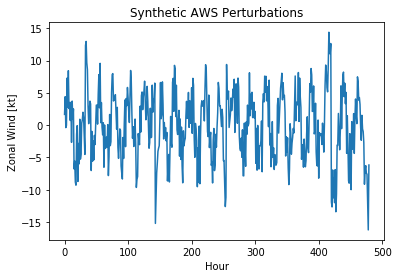

In [81]:
plt.title('Synthetic AWS Perturbations')
plt.plot(x[0:480],pert_aws[0:480])
plt.xlabel('Hour')
plt.ylabel('Zonal Wind [kt]')
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/'
            + 'forecast_verification_paper/reviewer_response_figures/reviewer_pert.png', dpi=200)

In [82]:
# Calculate the mean diurnal signals, and corresponding estimates from the perturbations
mean_diurnal_aws = np.zeros(24)
mean_diurnal_off = np.zeros(24)
mean_diurnal_mg = np.zeros(24)

mean_pert_aws = np.zeros(24)
mean_pert_off = np.zeros(24)
mean_pert_mg = np.zeros(24)

std_pert_aws = np.zeros(24)
std_pert_off = np.zeros(24)
std_pert_mg = np.zeros(24)

for i in np.arange(0,24):
    mean_pert_aws[i] = np.mean(pert_aws[i::24])
    mean_pert_off[i] = np.mean(pert_off[i::24])
    mean_pert_mg[i] = np.mean(pert_mg[i::24])
    
    std_pert_aws[i] = np.std(pert_aws[i::24])/np.sqrt(len(pert_aws[i::24]))
    std_pert_off[i] = np.std(pert_off[i::24])/np.sqrt(len(pert_off[i::24]))
    std_pert_mg[i] = np.std(pert_mg[i::24])/np.sqrt(len(pert_mg[i::24]))
    
    mean_diurnal_aws[i] = np.mean(diurnal_aws[i::24]) 
    mean_diurnal_off[i] = np.mean(diurnal_off[i::24])
    mean_diurnal_mg[i] = np.mean(diurnal_mg[i::24])

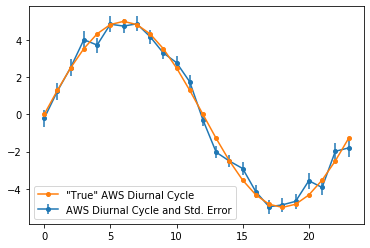

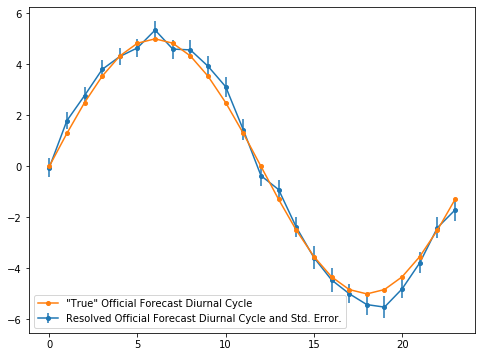

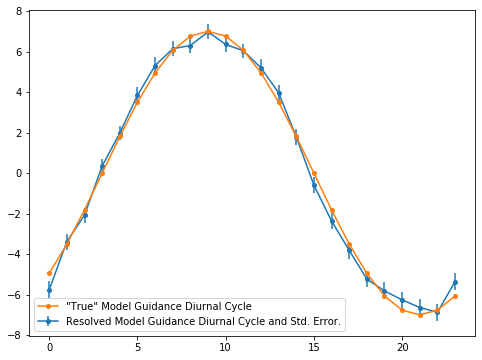

In [83]:
hours = np.arange(0,24)

plt.figure()
plt.errorbar(hours,mean_pert_aws, yerr=std_pert_aws, markersize=4, marker='o',
             label='AWS Diurnal Cycle and Std. Error',zorder=0)
plt.plot(hours,mean_diurnal_aws,'-o', markersize=4,
         label='"True" AWS Diurnal Cycle', zorder=1,
         )
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/'
            + 'forecast_verification_paper/reviewer_response_figures/reviewer_mean_pert.png', dpi=200)

plt.figure(figsize=(8,6))
plt.errorbar(hours,mean_pert_off, yerr=std_pert_off, markersize=4, marker='o',
             label='Resolved Official Forecast Diurnal Cycle and Std. Error.',zorder=0)
plt.plot(hours,mean_diurnal_off,'-o', markersize=4,
         label='"True" Official Forecast Diurnal Cycle', zorder=1,
         )
plt.legend()

plt.figure(figsize=(8,6))
plt.errorbar(hours,mean_pert_mg, yerr=std_pert_mg, markersize=4, marker='o',
             label='Resolved Model Guidance Diurnal Cycle and Std. Error.',zorder=0)
plt.plot(hours,mean_diurnal_mg,'-o', markersize=4,
         label='"True" Model Guidance Diurnal Cycle', zorder=1,
         )
plt.legend()

In [84]:
# Calculate the difference of absolute errors directly from the diurnal signal and from the perturbations
diurnal_DAE = np.abs(diurnal_mg-diurnal_aws)-np.abs(diurnal_off-diurnal_aws)
true_DAE = np.abs(diurnal_mg+noise_mg-diurnal_aws-noise_aws)-np.abs(diurnal_off+noise_off-diurnal_aws-noise_aws)
DAE = np.abs(pert_mg-pert_aws)-np.abs(pert_off-pert_aws)
DAE_no_slow = np.abs(pert_no_slow_mg-pert_no_slow_aws)-np.abs(pert_no_slow_off-pert_no_slow_aws)

mean_DAE = np.zeros(24)
mean_diurnal_DAE = np.zeros(24)
mean_no_slow_DAE = np.zeros(24)
std_DAE = np.zeros(24)
for i in np.arange(0,24):
    mean_DAE[i] = np.mean(DAE[i::24])
    mean_diurnal_DAE[i] = np.mean(diurnal_DAE[i::24])
    mean_no_slow_DAE[i] = np.mean(DAE_no_slow[i::24])
    std_DAE[i] = np.std(DAE[i::24])/np.sqrt(len(DAE[i::24]))

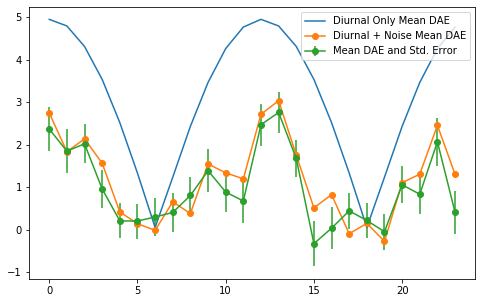

In [85]:
plt.figure(figsize=(8,5))
plt.plot(hours,mean_diurnal_DAE,label='Diurnal Only Mean DAE')
plt.plot(hours,mean_no_slow_DAE,'-o', fillstyle='full', label='Diurnal + Noise Mean DAE')
plt.errorbar(hours,mean_DAE,marker='o',yerr=std_DAE,label='Mean DAE and Std. Error')
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/'
            + 'forecast_verification_paper/reviewer_response_figures/reviewer_mean_DAE.png', dpi=200)